In [3]:
import pathlib

from falafel import utils, qe

from pixell import lensing, curvedsky

import solenspipe

import pytempura

import healpy as hp

import numpy as np

import constants as const

import matplotlib.pyplot as plt

%matplotlib inline


In [4]:


def gauss_beam(ell: np.ndarray, fwhm: float):
    '''
    Parameters
    ----------
    ell: np.ndarray
    fwhm: float, in arcmin

    Returns
    -------
    gauss_beam: np.ndarray
    '''
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))


def dummy_teb(alms):
    '''
    Creates a list of maps with the order [Tlm, Elm, Blm] and Elm, Blm = 0, 0
    '''
    return [alms, np.zeros_like(alms), np.zeros_like(alms)]

def filter_alms(alms, tcls, lmin, lmax):
    '''
    Takes input alms, and makes an isotropic filtering with tcls
    '''
    if len(alms)!=3:
        alms = dummy_teb(alms)
    alms_filtered = utils.isotropic_filter(alms,
            tcls, lmin, lmax, ignore_te = True)
    return alms_filtered


def fnu(nu, tcmb = const.default_tcmb):
    """
    nu in GHz
    tcmb in Kelvin
    """
    nu = np.asarray(nu)
    mu = const.H_CGS*(1e9*nu)/(const.K_CGS*tcmb)
    ans = mu/np.tanh(mu/2.0) - 4.0
    return ans

def tsz_factor_for_ymap(freq, tcmb = const.default_tcmb):
    return fnu(freq) * tcmb * 1e6

def process_tsz(comptony, freq, tcmb = const.default_tcmb):
    return tsz_factor_for_ymap(freq = freq, tcmb = tcmb) * comptony



nside = 4096
noise_sigma = 17
mlmax = 6000
fwhm = 1.4

kappa_lmin, kappa_lmax = 100, 3000

source_dir = pathlib.Path('/global/cscratch1/sd/omard/scatteringtfms/sims/')

kappa_name = 'healpix_4096_KappaeffLSStoCMBfullsky.fits'
cmb_name = 'Sehgalsimparams_healpix_4096_KappaeffLSStoCMBfullsky_phi_SimLens_Tsynfastnopell_fast_lmax8000_nside4096_interp2.5_method1_1_lensed_map.fits'

freq = 148 #GHz

tsz_power = 'Sehgal_sim_tSZPS_unbinned_8192_y_rescale0p75.txt'
ksz_power = 'kSZ_PS_Sehgal_healpix_Nside4096_DeltaT_uK.txt'

ell, cltsz = np.loadtxt(source_dir/tsz_power, unpack = True)
cltsz *= (tsz_factor_for_ymap(freq))**2
ell, clksz = np.loadtxt(source_dir/ksz_power, unpack = True)

#names = [kappa_name, cmb_name]
#maps = [hp.read_map(source_dir/name) for name in names]

#alms = [hp.map2alm(mappa, lmax = mlmax) for mappa in maps]
cmboutname = 'cmb'
kappaoutname = 'kappa'
kszoutname = 'ksz'
tszoutname = 'tsz'
nomi = [kappaoutname, cmboutname, kszoutname, tszoutname]
#[hp.write_alm(source_dir/f'{nome}_alm.fits', alm) for nome, alm in zip(nomi, alms)]

alms = [hp.read_alm(source_dir/f'{nome}_alm.fits') for nome in nomi]

ells = np.arange(mlmax+1)

fgs = clksz+cltsz
fgpower = np.interp(ells, ell, fgs)*0.

bfact = gauss_beam(ells, fwhm)
Nl_tt = (noise_sigma*np.pi/180./60.)**2./bfact #beam deconvolved noise
#HAVE TO INCLUDE FOREGROUND POWER TOO
Nl_tt = np.nan_to_num(Nl_tt+fgpower)
nells = {"TT": Nl_tt, "EE": 2*Nl_tt, "BB": 2*Nl_tt}


In [5]:

px = qe.pixelization(nside = nside)

ucls, tcls = utils.get_theory_dicts(grad = True, nells = nells, lmax = mlmax)

_, ls, Als, R_src_tt, Nl_g, Nl_c, Nl_g_bh = solenspipe.get_tempura_norms(
        est1 = 'TT', est2 = 'TT', ucls = ucls, tcls = tcls, lmin = kappa_lmin, lmax = kappa_lmax, mlmax = mlmax)

#R_src_tt = pytempura.get_cross('SRC', 'TT', ucls, tcls, kappa_lmin, kappa_lmax, k_ellmax = mlmax)

norm_stuff = {"ls": ls, "Als": Als, "R_src_tt": R_src_tt,
                  "Nl_g": Nl_g, "Nl_c": Nl_c, "Nl_g_bh": Nl_g_bh,
    }

qfunc = solenspipe.get_qfunc(px, ucls, mlmax, "TT", Al1 = Als['TT'])
qfunc_bh = solenspipe.get_qfunc(px, ucls, mlmax, "TT", est2 = 'SRC', Al1 = Als['TT'], 
                                Al2 = Als['src'], R12 = R_src_tt)

qfunc2 = lambda X,Y: qe.qe_source(px, mlmax, fTalm=Y[0],xfTalm=X[0], profile = None)

qfunc_shear = lambda X,Y: qe.qe_shear(px, mlmax, Talm = X[0], fTalm = Y[0])


kappa_alm, cmb_alm, ksz_alm, tsz_alm = alms
tsz_alm = process_tsz(tsz_alm, freq)

cmb_alm = utils.change_alm_lmax(cmb_alm, mlmax)
cmb_alm_filtered = filter_alms(cmb_alm, tcls, kappa_lmin, kappa_lmax)

versions = ['shear']#['qe', 'bh']
functions = [qfunc_shear] #[qfunc, qfunc_bh]


 Response (TT)


In [27]:
der = lambda x: np.gradient(x)
filt_t = lambda x: (1./(x*(tcls['TT'])**2))*der(tcls['TT'])
almt = qe.filter_alms(np.array([cmb_alm]), filt_t(ells),lmin = kappa_lmin, lmax = kappa_lmax)

alms = qe.almxfl(np.stack((almt, almt)), np.sqrt((ells-1.)*ells*(ells+1.)*(ells+2.)))

/tmp/ipykernel_485/2703318173.py:2: RuntimeWarning: divide by zero encountered in true_divide
  filt_t = lambda x: (1./(x*(tcls['TT'])**2))*der(tcls['TT'])


ValueError: Buffer has wrong number of dimensions (expected 2, got 3)

In [29]:
qe.almxfl?

Signature: qe.almxfl(alm, fl)
Docstring: <no docstring>
File:      ~/.conda/envs/foregrounds/lib/python3.8/site-packages/falafel-0.1.0-py3.8.egg/falafel/qe.py
Type:      function


In [22]:
qe.get_mlmax(np.array([cmb_alm[0]]))

0

In [10]:
cmb_alm.shape

(18009001,)

In [11]:

for function, version in zip(functions, versions):
    phi_recon_alms = function([cmb_alm], [cmb_alm])
    kappa_recon_alms = lensing.phi_to_kappa(phi_recon_alms)

    cl_kk_input_output = curvedsky.alm2cl(kappa_recon_alms, kappa_alm)
    cl_kk_input = curvedsky.alm2cl(kappa_alm)

    np.save(source_dir/f'kappa_reconstructed_{version}', kappa_recon_alms[0])

    plt.loglog(cl_kk_input_output, label = '$\hat{\kappa}\kappa$')
    plt.loglog(cl_kk_input, label = '$\kappa\kappa$')
    plt.legend()
    plt.savefig(f'reconstruction_{version}.png')
    plt.close()



In [12]:
cl_kk_input_output = curvedsky.alm2cl(kappa_recon_alms, kappa_alm)
cl_kk_input = curvedsky.alm2cl(kappa_alm)

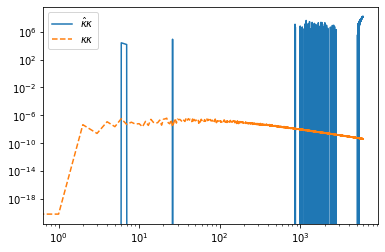

In [13]:
plt.loglog(cl_kk_input_output, label = '$\hat{\kappa}\kappa$')
plt.loglog(cl_kk_input, ls = '--', label = '$\kappa\kappa$')
plt.legend()
plt.show()